## IMSE 586 Timeseries implementation using house sales data

In [53]:
# Importing libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA

In [54]:
# Read in Data.
df_houses = pd.read_csv('SeriesReport-data.csv', skiprows = 7)

In [55]:
# First five rows in the dataframe.
df_houses.head()

,Period,Value
0,Jan-2010,231.0
1,Feb-2010,229.0
2,Mar-2010,227.0
3,Apr-2010,216.0
4,May-2010,215.0


In [56]:
# Last five rows in the dataframe.
df_houses.tail()

,Period,Value
115,Aug-2019,326.0
116,Sep-2019,323.0
117,Oct-2019,327.0
118,Nov-2019,NaN
119,Dec-2019,NaN


In [57]:
df_houses.dtypes

Period     object
Value     float64
dtype: object

In [58]:
df_houses.shape

(120, 2)

In [59]:
df_houses.describe()

,Value
count,118.000000
mean,225.593220
std,60.082029
min,142.000000
25%,179.500000
50%,213.000000
75%,267.500000
max,349.000000


# Drop the null records

In [60]:
df_houses.isnull().sum()

Period    0
Value     2
dtype: int64

In [61]:
df_houses.dropna(inplace = True)
df_houses.tail()

,Period,Value
113,Jun-2019,326.0
114,Jul-2019,327.0
115,Aug-2019,326.0
116,Sep-2019,323.0
117,Oct-2019,327.0


# Converting month and year in the Period column to pandas datetime format, and setting it as the index of the dataframe. Then droping the Period column.

In [62]:
df_houses['date'] = pd.to_datetime(df_houses.Period, format = '%b-%Y')

df_houses.set_index('date', inplace = True)

df_houses.drop('Period', axis = 1, inplace = True)

df_houses.head()

,Value
date,
2010-01-01,231.0
2010-02-01,229.0
2010-03-01,227.0
2010-04-01,216.0
2010-05-01,215.0


# Line plot of the monthly sales and 12-month moving average of the sales

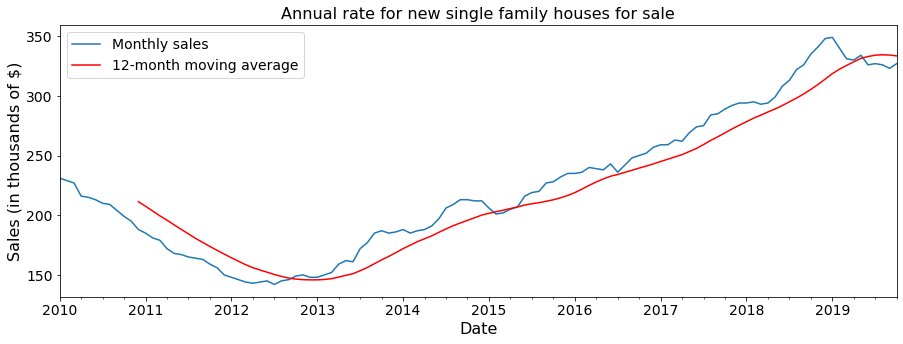

In [63]:
plt.figure(figsize = (15, 5))

df_houses.Value.plot(label='Monthly sales')

df_houses.Value.rolling(12).mean().plot(label='12-month moving average', color = 'red')

plt.xlabel('Date', fontsize = 16)
plt.ylabel('Sales (in thousands of $)', fontsize = 16)
plt.title('Annual rate for new single family houses for sale', fontsize = 16)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 14)

plt.show()

# Total sales for a 3-month rolling window

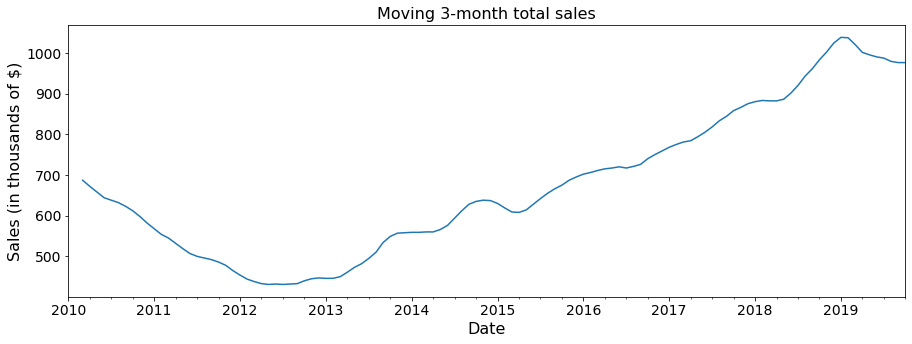

In [64]:
plt.figure(figsize = (15, 5))

df_houses.Value.rolling(3).sum().plot()

plt.xlabel('Date', fontsize = 16)
plt.ylabel('Sales (in thousands of $)', fontsize = 16)
plt.title('Moving 3-month total sales', fontsize = 16)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.show()

# Transform the data to stabilize the variance in the sales data

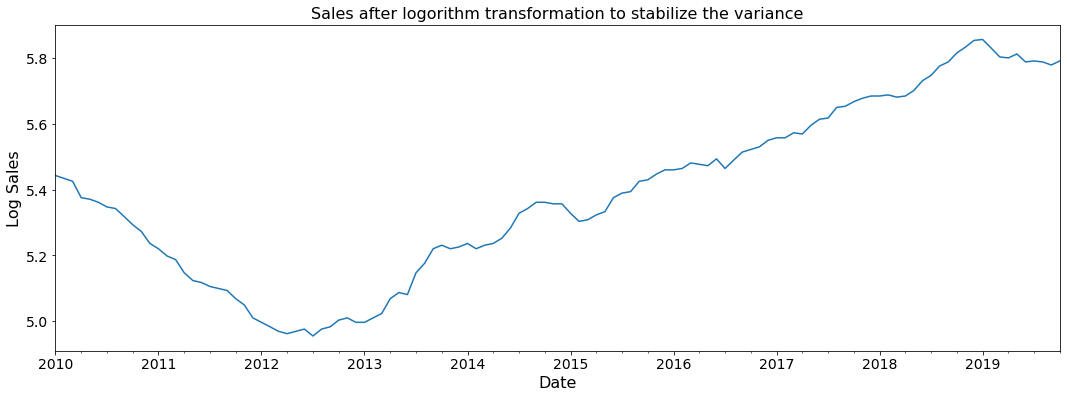

In [65]:
plt.figure(figsize = (18, 6))

df_houses['log_sales'] = np.log(df_houses.Value)

df_houses.log_sales.plot()

plt.xlabel('Date', fontsize = 16)
plt.ylabel('Log Sales', fontsize = 16)
plt.title('Sales after logorithm transformation to stabilize the variance', fontsize = 16)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.show()

# detrended data

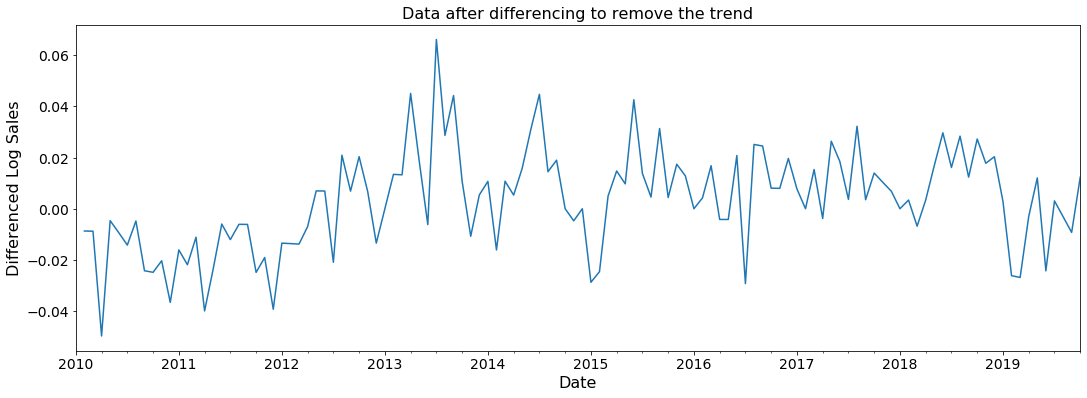

In [66]:
plt.figure(figsize = (18, 6))

df_houses['log_sales_df1'] = df_houses.log_sales.diff(1)

df_houses.log_sales_df1.plot()

plt.xlabel('Date', fontsize = 16)
plt.ylabel('Differenced Log Sales', fontsize = 16)
plt.title('Data after differencing to remove the trend', fontsize = 16)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.show()

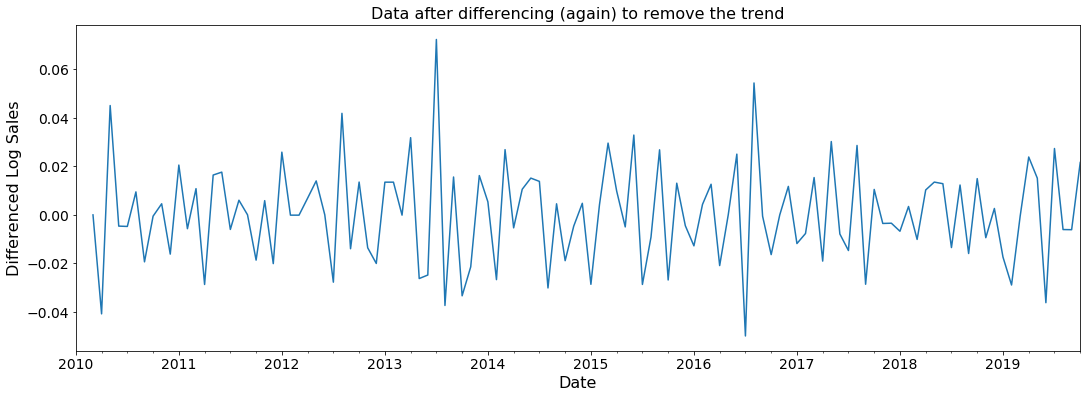

In [67]:
## detrend again to get stabilize the constant mean and variance.

plt.figure(figsize = (18, 6))

df_houses['log_sales_diff'] = df_houses.log_sales_df1.diff(1)

df_houses.log_sales_diff.plot()

plt.xlabel('Date', fontsize = 16)
plt.ylabel('Differenced Log Sales', fontsize = 16)
plt.title('Data after differencing (again) to remove the trend', fontsize = 16)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.show()

# Adjust for seasonality

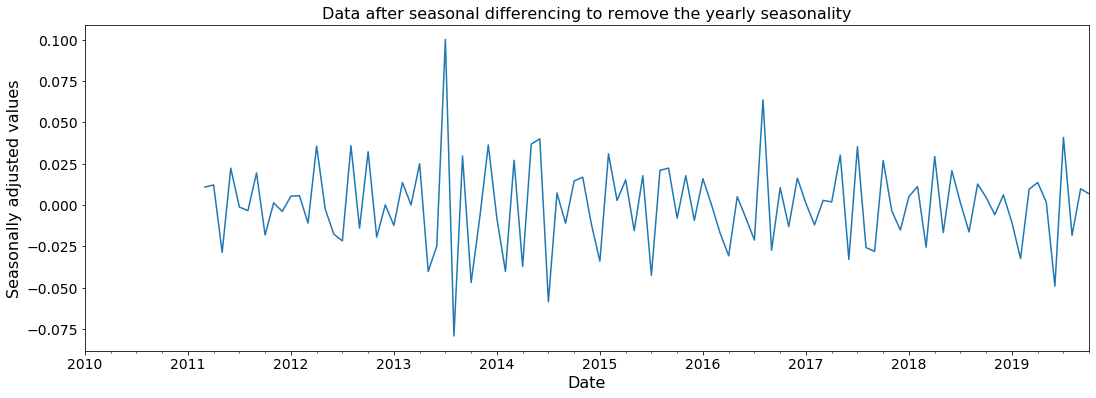

In [68]:
plt.figure(figsize = (18, 6))

df_houses['stationary'] = df_houses.log_sales_diff.diff(periods = 12)

df_houses.stationary.plot()

plt.xlabel('Date', fontsize = 16)
plt.ylabel('Seasonally adjusted values', fontsize = 16)
plt.title('Data after seasonal differencing to remove the yearly seasonality', fontsize = 16)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.show()

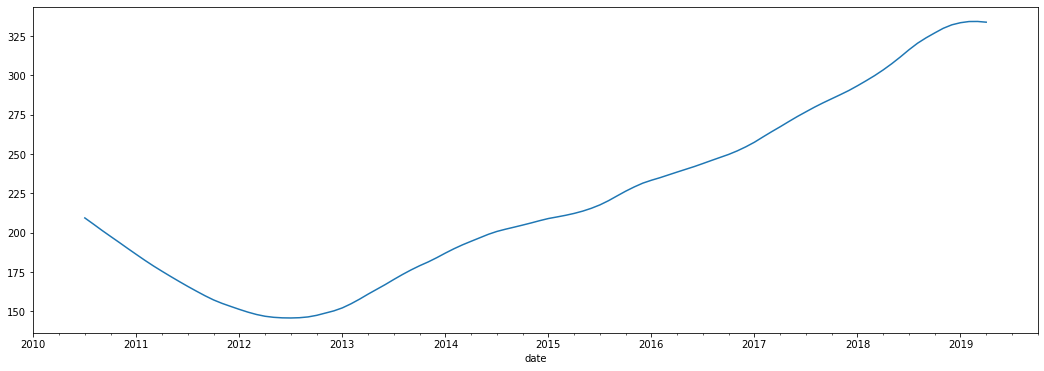

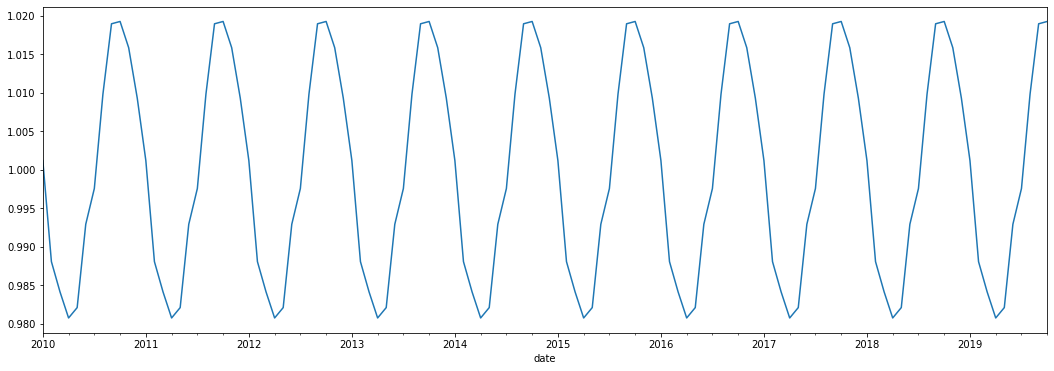

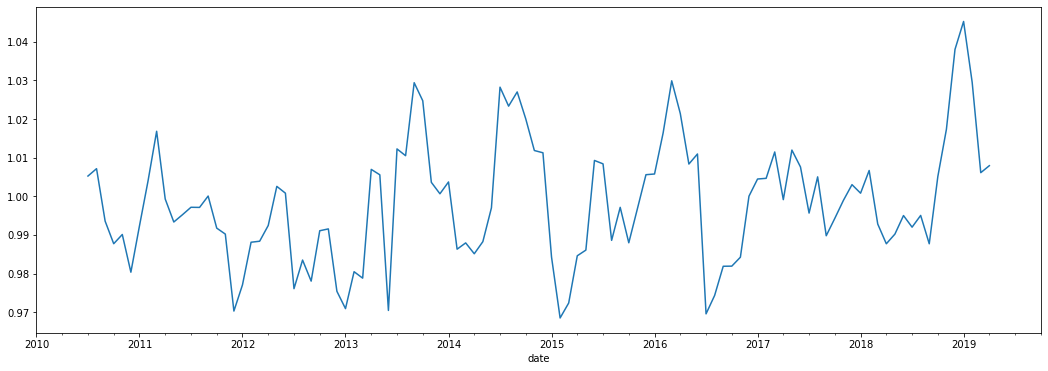

In [69]:
## Another way to do seasonal decompose

import statsmodels.api as sm

s = sm.tsa.seasonal_decompose(df_houses.Value, model ='multiplicative')

plt.figure(figsize = (18, 6))

s.trend.plot(label='trend')

plt.figure(figsize = (18, 6))

s.seasonal.plot()

plt.figure(figsize = (18, 6))

s.resid.plot()

In [70]:
df_houses['log_sales'] = np.log(df_houses.Value)

df_houses['log_sales_diff'] = df_houses.log_sales.diff(1)

df_houses['stationary'] = df_houses.log_sales_diff.diff(periods = 12)

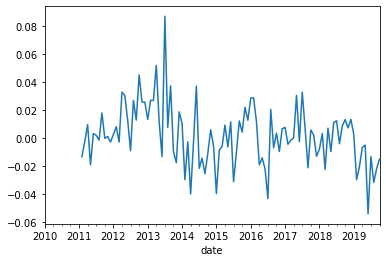

In [71]:
df_houses.stationary.plot()

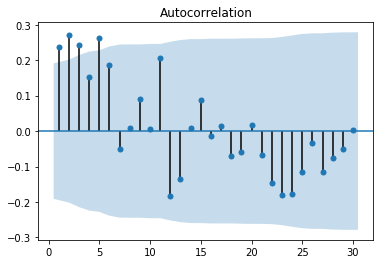

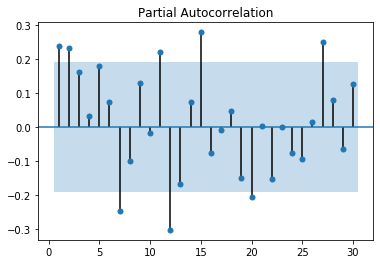

In [72]:
df_houses.stationary.dropna(inplace = True)  # drop the null values caused by differencing

sm.graphics.tsa.plot_acf(df_houses.stationary, lags = 30, zero = False)

sm.graphics.tsa.plot_pacf(df_houses.stationary, lags = 30, zero = False)

#sm.graphics.tsa.plot_acf(df_houses.Value, lags = 30, zero = False)

plt.show()

# AR Model

In [73]:
X = df_houses.dropna()

# use the last 12 month as the test set
t = -12
train = X[:t]
test = X[t:]

model = AR(train.stationary, freq = 'MS')

model_fitted = model.fit()

print('The chosen order p for the AR model is ' + str(model_fitted.k_ar) + '.')
print('')
print('The model coefficients are:')
print(model_fitted.params)

The chosen order p for the AR model is 12.

The model coefficients are:
const             0.002313
L1.stationary     0.182558
L2.stationary     0.184792
L3.stationary     0.116561
L4.stationary    -0.012940
L5.stationary     0.160661
L6.stationary     0.093283
L7.stationary    -0.181461
L8.stationary    -0.079595
L9.stationary     0.150845
L10.stationary   -0.016504
L11.stationary    0.227336
L12.stationary   -0.308558
dtype: float64


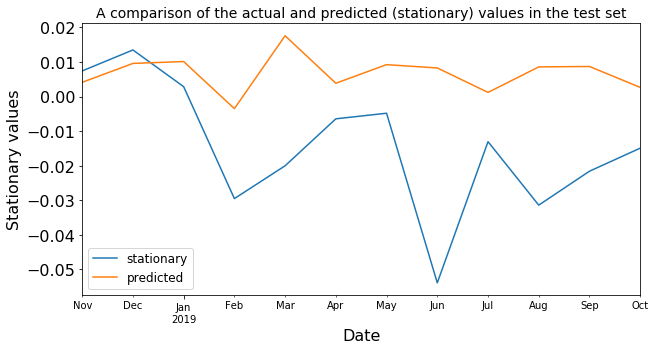

In [74]:
predictions = model_fitted.predict(start = len(train), end = len(X) - 1)

predicted = pd.Series(predictions, index = df_houses[t:].index, name = 'predicted')

plt.figure(figsize = (10, 5))

test.stationary.plot()

predicted.plot()

plt.xlabel('Date', fontsize = 16)
plt.ylabel('Stationary values', fontsize = 16)
plt.title('A comparison of the actual and predicted (stationary) values in the test set', fontsize = 14)

plt.yticks(fontsize = 16)

plt.legend(fontsize = 12)

plt.show()

### Convert the predictions back to original forms

In [75]:
pred = [np.exp(predicted[0]) * train.Value[-1] * train.Value[-12] / train.Value[-13]]

for i in range(1, 12):   
    pred.append(np.exp(predicted[i]) * pred[-1] * train.Value[i-12] / train.Value[i-13])
    
pred_final = pd.Series(pred, index = df_houses[t:].index, name = 'predicted')

pd.concat([test.Value, pred_final.round(1)], axis = 1)



,Value,predicted
date,,
2018-11-01,341.0,339.9
2018-12-01,348.0,345.5
2019-01-01,349.0,349.0
2019-02-01,340.0,349.0
2019-03-01,331.0,352.8
2019-04-01,330.0,355.4
2019-05-01,334.0,364.8
2019-06-01,326.0,378.9
2019-07-01,327.0,385.5


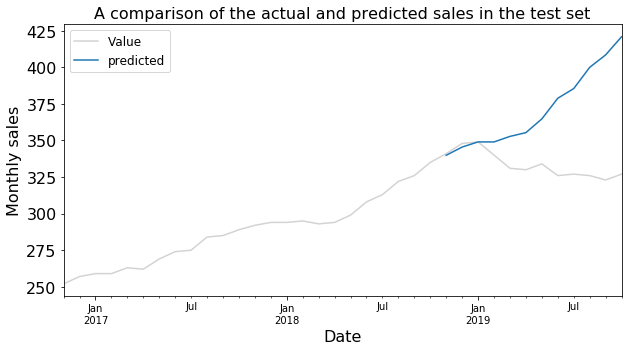

In [76]:
plt.figure(figsize = (10, 5))

df_houses.Value[-36:].plot(color = 'lightgray')

pred_final.plot()

plt.xlabel('Date', fontsize = 16)
plt.ylabel('Monthly sales', fontsize = 16)
plt.title('A comparison of the actual and predicted sales in the test set', fontsize = 16)

plt.yticks(fontsize = 16)

plt.legend(fontsize = 12)

plt.show()

In [77]:
from sklearn.metrics import mean_squared_error

RMSE = np.sqrt(mean_squared_error(pred_final, df_houses.Value[t:]))

print('The RMSE is ' + str(RMSE.round(1)) + '.')

The RMSE is 50.0.


# ARMA Model

In [78]:
model = ARMA(train.stationary, freq = 'MS', order = (3 , 3))
model_fitted = model.fit()

print('The model coefficients are:')
print(model_fitted.params)

The model coefficients are:
const               0.003726
ar.L1.stationary   -0.252536
ar.L2.stationary   -0.028609
ar.L3.stationary    0.737818
ma.L1.stationary    0.388357
ma.L2.stationary    0.426138
ma.L3.stationary   -0.587849
dtype: float64


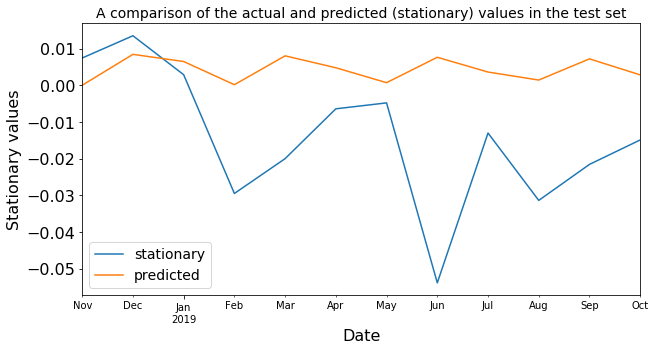

In [79]:
predictions = model_fitted.predict(start = len(train), end = len(X) - 1)

predicted = pd.Series(predictions, index = df_houses[t:].index, name = 'predicted')

plt.figure(figsize = (10, 5))

test.stationary.plot()

predicted.plot()

plt.xlabel('Date', fontsize = 16)
plt.ylabel('Stationary values', fontsize = 16)
plt.title('A comparison of the actual and predicted (stationary) values in the test set', fontsize = 14)

plt.yticks(fontsize = 16)

plt.legend(fontsize = 14)

plt.show()

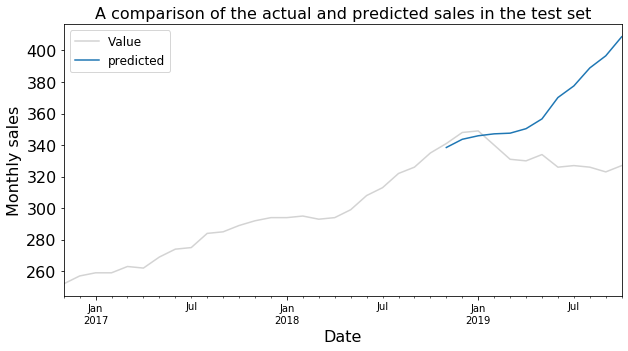

In [80]:
pred = [np.exp(predicted[0]) * train.Value[-1] * train.Value[-12] / train.Value[-13]]

for i in range(1, 12):   
    pred.append(np.exp(predicted[i]) * pred[-1] * train.Value[i-12] / train.Value[i-13])
    
pred_final = pd.Series(pred, index = df_houses[t:].index, name = 'predicted')

pd.concat([test.Value, pred_final.round(1)], axis = 1)

plt.figure(figsize = (10, 5))

df_houses.Value[-36:].plot(color = 'lightgray')

pred_final.plot()

plt.xlabel('Date', fontsize = 16)
plt.ylabel('Monthly sales', fontsize = 16)
plt.title('A comparison of the actual and predicted sales in the test set', fontsize = 16)

plt.yticks(fontsize = 16)

plt.legend(fontsize = 12)

plt.show()

In [81]:
RMSE = np.sqrt(mean_squared_error(pred_final, df_houses.Value[t:]))

print('The RMSE is ' + str(RMSE.round(1)) + '.')

The RMSE is 42.7.
